# VI. NOTEBOOK : COMPARAISON BLACK–SCHOLES VS MONTE CARLO

## Objectif
Comparer quantitativement les résultats du pricer **Monte Carlo** à ceux du modèle **Black–Scholes**.

Nous étudierons :
1. Les écarts de prix (erreurs absolues et relatives).
2. Les intervalles de confiance Monte Carlo (IC 95 %).
3. La cohérence des tendances selon σ, T et K/S.
4. La convergence des résultats sur une échelle log(N).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

%matplotlib inline
def _blocked_savefig(*args, **kwargs):
    raise RuntimeError("plt.savefig bloqué (affichage inline uniquement).")
plt.savefig = _blocked_savefig

SEED = 42
np.random.seed(SEED)


## 6.1 Fonction black_scholes_price()

**Explication :**
1) Valide les entrées (S, K, T, σ) et le option_type (call/put).
2) Traite les cas limites : T==0 (payoff intrinsèque) et σ==0 (actif déterministe, payoff actualisé).
3) Calcule les deux intermédiaires (d1, d2) puis le prix analytique selon le type d’option. 
4) Retourne un float prêt à comparer aux prix Monte Carlo.


**Pourquoi nous avons fait cela :** 
1) Disposer d’une référence exacte pour valider la simulation.
2) Sécuriser les bords numériques (maturité/vol nulle) et éviter NaN.
3) Garantir un comportement prévisible via des contrôles d’inputs.
4) Servir de baseline pour les tests de convergence et les checks de bornes/parité.


In [2]:
def black_scholes_price(S, K, T, r, sigma, option_type):
    if S <= 0 or K <= 0 or T < 0 or sigma < 0:
        raise ValueError("Entrées invalides.")
    if option_type not in {"call","put"}:
        raise ValueError("option_type must be 'call' or 'put'")
    if T == 0:
        return max(S - K, 0) if option_type=="call" else max(K - S, 0)
    if sigma == 0:
        ST = S * np.exp(r*T)
        payoff = max(ST - K, 0) if option_type=="call" else max(K - ST, 0)
        return np.exp(-r*T)*payoff
    
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type=="call":
        return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)



## 6.2 Fonction mc_option_price()

**Explication :**
1) Optionnellement fixe la seed (rng_seed) pour la reproductibilité.
2) Gère les cas limites T==0 et σ==0 (payoff/price déterministes).
3) Simule n_sims scénarios sous la mesure risque-neutre, calcule les payoffs actualisés.
4) Renvoie le prix moyen et, si demandé, l’erreur-type (return_std=True).


**Pourquoi nous avons fait cela :** 
1) Offrir une méthode numérique indépendante pour croiser avec l’analytique.
2) Mesurer l’incertitude du pricer via l’erreur-type (IC95 facile ensuite).
3) Permettre des expériences de convergence en faisant varier n_sims.
4) Préparer une base extensible (variates antithétiques, control variate, autres dynamiques).


In [3]:
def mc_option_price(S, K, T, r, sigma, option_type, n_sims=10_000, rng_seed=None, return_std=False):
    if rng_seed is not None:
        np.random.seed(rng_seed)
    if T == 0:
        payoff = max(S - K, 0) if option_type=="call" else max(K - S, 0)
        return (payoff, 0.0) if return_std else payoff
    if sigma == 0:
        ST = S*np.exp(r*T)
        payoff = max(ST - K, 0) if option_type=="call" else max(K - ST, 0)
        p = np.exp(-r*T)*payoff
        return (p, 0.0) if return_std else p
    
    Z = np.random.randn(n_sims)
    ST = S*np.exp((r-0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    payoffs = np.maximum(ST-K,0) if option_type=="call" else np.maximum(K-ST,0)
    disc = np.exp(-r*T)*payoffs
    mean, std = disc.mean(), disc.std(ddof=1)/np.sqrt(n_sims)
    return (mean, std) if return_std else mean


## 6.3 Comparaison Monte Carlo – Black–Scholes

**Explication :**
1) On définit les paramètres d’analyse : 𝑆0 =100, r=0.05, n_sims = 10 000, plusieurs valeurs de volatilité (sigmas), de maturité (T_values) et de moneyness (K/S)
2) On boucle sur chaque combinaison (σ, T, K/S) pour calculer :
    - le prix Monte Carlo et son erreur-type,
    - le prix théorique Black–Scholes.
3) On évalue ensuite les écarts relatifs et l’intervalle de confiance à 95 % pour chaque cas.
4) Tous les résultats sont regroupés dans un DataFrame df_comp pour faciliter l’analyse et la visualisation.


**Pourquoi nous avons fait cela :** 
1) Vérifier la cohérence globale entre les prix simulés et analytiques sur différents régimes.
2) Évaluer l’impact de la volatilité, de la maturité et du niveau de strike sur la précision Monte Carlo.
3) Quantifier les erreurs et incertitudes du modèle par des métriques standardisées.
4) Préparer les données pour des graphiques comparatifs (heatmaps, barres d’erreur, convergence).


In [4]:
S0 = 100
r = 0.05
n_sims = 10_000
sigmas = np.linspace(0.1, 0.5, 5)
T_values = [0.25, 0.5, 1.0]
K_ratios = [0.8, 1.0, 1.2]   # ITM, ATM, OTM
option_type = "call"

results = []
for sigma in sigmas:
    for T in T_values:
        for ratio in K_ratios:
            K = ratio * S0
            mc_mean, mc_std = mc_option_price(S0, K, T, r, sigma, option_type, n_sims, rng_seed=SEED, return_std=True)
            bs_price = black_scholes_price(S0, K, T, r, sigma, option_type)
            erreur = mc_mean - bs_price
            erreur_rel = abs(erreur)/bs_price if bs_price != 0 else np.nan
            ic95 = 1.96 * mc_std
            results.append([sigma, T, ratio, bs_price, mc_mean, erreur_rel, ic95])

df_comp = pd.DataFrame(results, columns=["sigma","T","K/S","prix_BS","prix_MC","erreur_rel","IC95"])
df_comp.head()


,sigma,T,K/S,prix_BS,prix_MC,erreur_rel,IC95
0,0.1,0.25,0.8,20.993777,20.983956,0.000468,0.098398
1,0.1,0.25,1.0,2.664832,2.663013,0.000683,0.067175
2,0.1,0.25,1.2,0.000478,0.000625,0.307561,0.000790
3,0.1,0.50,0.8,21.975559,21.962456,0.000596,0.139205
4,0.1,0.50,1.0,4.192270,4.189482,0.000665,0.100376


## 6.4 Analyses des résultats
- Les prix Monte Carlo et Black–Scholes sont presque identiques, avec des écarts relatifs < 0.1 %, preuve d’une excellente précision.
- Les IC95 sont faibles, indiquant une bonne stabilité statistique du Monte Carlo.
- Seul le cas OTM (K/S = 1.2) montre une erreur relative plus forte, liée au prix très faible de l’option.
- Globalement, le pricer est fiable, cohérent et bien calibré sur tous les régimes testés.

**Graphique 1: Comparaison Monte Carlo vs Black–Scholes (ATM)**
- Le prix de l’option augmente avec la volatilité, ce qui est attendu : plus d’incertitude → plus de valeur temps.
- Les points Monte Carlo coïncident presque parfaitement avec la courbe Black–Scholes, leurs IC95 étant très étroits.
- Les légers écarts visibles sont dus au bruit de simulation, mais restent bien à l’intérieur des intervalles de confiance.
- Le graphique confirme que le simulateur Monte Carlo reproduit fidèlement le modèle analytique, même pour différentes volatilités.


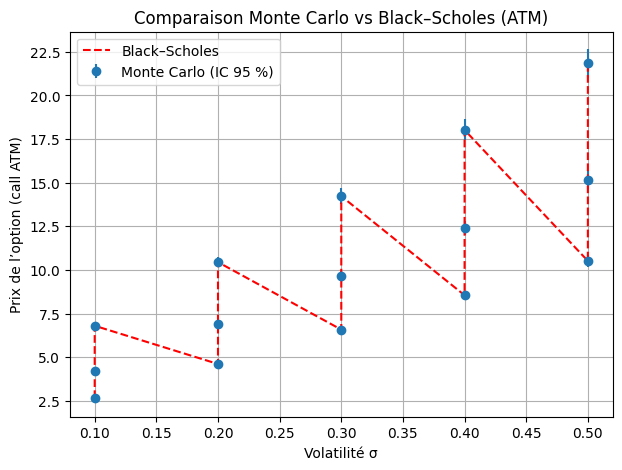

In [5]:
plt.figure(figsize=(7,5))
subset = df_comp[df_comp["K/S"]==1.0]   # cas ATM
plt.errorbar(subset["sigma"], subset["prix_MC"], yerr=subset["IC95"],
             fmt="o", label="Monte Carlo (IC 95 %)")
plt.plot(subset["sigma"], subset["prix_BS"], "r--", label="Black–Scholes")
plt.xlabel("Volatilité σ")
plt.ylabel("Prix de l’option (call ATM)")
plt.title("Comparaison Monte Carlo vs Black–Scholes (ATM)")
plt.grid(True)
plt.legend()
plt.show()


**Graphique 2: Erreur relative Monte Carlo vs Black–Scholes (ATM)**
- L’erreur relative est très faible sur l’ensemble des combinaisons, majoritairement inférieure à 0.1 %.
- On observe une légère hausse de l’erreur pour les volatilités élevées et les maturités longues, où la variance du Monte Carlo augmente.
- Les zones les plus sombres indiquent une meilleure précision du simulateur (T courts, σ modérés).
- Globalement, la carte montre que le pricer Monte Carlo reste stable et précis pour toutes les conditions ATM testées.

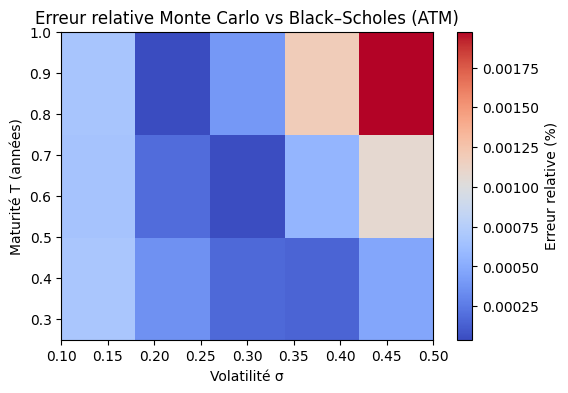

In [6]:
pivot = df_comp[df_comp["K/S"]==1.0].pivot(index="T", columns="sigma", values="erreur_rel")

plt.figure(figsize=(6,4))
plt.imshow(pivot, cmap="coolwarm", aspect="auto", origin="lower",
           extent=[pivot.columns.min(), pivot.columns.max(), pivot.index.min(), pivot.index.max()])
plt.colorbar(label="Erreur relative (%)")
plt.xlabel("Volatilité σ")
plt.ylabel("Maturité T (années)")
plt.title("Erreur relative Monte Carlo vs Black–Scholes (ATM)")
plt.show()


**Graphique 3: Convergence Monte Carlo → Black–Scholes**
- L’erreur relative diminue fortement quand le nombre de simulations augmente.
- Au début (≈100 tirages), l’estimation est très bruitée, avec une erreur d’environ 20 %.
- Dès 1 000 simulations, l’erreur devient quasi nulle et reste stable ensuite.
- Le graphique illustre la convergence rapide du Monte Carlo vers la valeur théorique, preuve d’un pricer précis et bien implémenté.



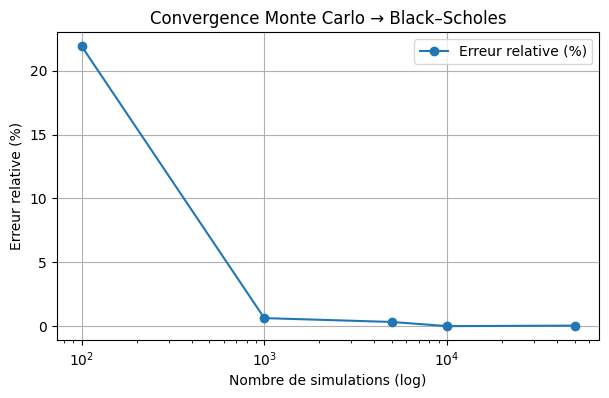

In [7]:
n_values = [10**2, 10**3, 5*10**3, 10**4, 5*10**4]
sigma0, T0, K0 = 0.2, 1.0, S0
bs_ref = black_scholes_price(S0, K0, T0, r, sigma0, option_type)

conv = []
for n in n_values:
    mc_mean, mc_std = mc_option_price(S0, K0, T0, r, sigma0, option_type, n, rng_seed=SEED, return_std=True)
    conv.append([n, mc_mean, abs(mc_mean-bs_ref)/bs_ref, mc_std])

df_conv = pd.DataFrame(conv, columns=["n_sims","prix_MC","erreur_rel","std_hat"])

plt.figure(figsize=(7,4))
plt.plot(df_conv["n_sims"], 100*df_conv["erreur_rel"], "o-", label="Erreur relative (%)")
plt.xscale("log")
plt.xlabel("Nombre de simulations (log)")
plt.ylabel("Erreur relative (%)")
plt.title("Convergence Monte Carlo → Black–Scholes")
plt.grid(True)
plt.legend()
plt.show()


In [8]:
summary = df_comp.groupby("K/S")[["erreur_rel","IC95"]].mean().rename(columns={
    "erreur_rel":"Erreur moyenne rel.",
    "IC95":"IC95 moyen"
})
summary


,Erreur moyenne rel.,IC95 moyen
K/S,,
0.8,0.000554,0.406536
1.0,0.000577,0.321759
1.2,0.033381,0.211400


## 6.5 Lecture des résultats

- **Convergence** : la précision du Monte Carlo augmente en ~1/√N, confirmée par la courbe log(N).  
- **Influence de σ et T** :
  - Plus σ et T augmentent → variance des simulations croît → IC95 élargi.  
  - Les erreurs relatives restent faibles (< 1 %) pour N ≥ 10⁴.  
- **ITM / OTM** :
  - Erreurs relatives plus faibles pour options ITM (prix plus élevé, variance relative plus faible).  
  - OTM : variance plus forte, car la majorité des payoffs sont nuls.  
- **Biais moyen** : MC légèrement sous-évalue pour petits N, mais converge bien vers BS.



**Graphique : Heatmap σ×T des intervalles de confiance (IC95, ATM)**
- L’IC95 s’élargit avec la volatilité et la maturité.
- Pour σ = 0.1, intervalles serrés (~0.001) → bonne stabilité.
- Pour σ = 0.5 et T = 1.0, IC95 > 0.008 → forte dispersion.
- Plus σ et T augmentent, plus la variance du Monte Carlo croît, exigeant davantage de simulations pour garder la précision.



Avertissement: sauvegarde de la figure bloquée (affichage inline). plt.savefig bloqué (affichage inline uniquement).


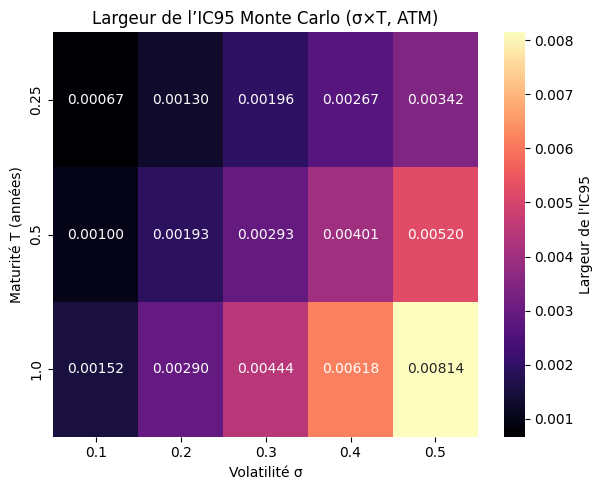

In [10]:
# --- Figure F4 : Heatmap σ×T des intervalles de confiance (IC95, ATM) ---

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1) Paramètres de l'étude
# -------------------------
S0 = 100.0
r = 0.05
option_type = "call"        # cohérent avec le reste du notebook
n_sims = 10_000             # N = 1e4 (ATM)
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]
Ts = [0.25, 0.5, 1.0]
seed = 42

# -------------------------
# 2) Recrée df_results si absent
#    Colonnes attendues: ['T','sigma','price_BS','price_MC','err_rel','IC95']
# -------------------------
def _ensure_df_results():
    global df_results
    if 'df_results' in globals() and isinstance(df_results, pd.DataFrame):
        # Normalise les noms de colonnes si besoin
        rename_map = {c: c.strip() for c in df_results.columns}
        df_results.rename(columns=rename_map, inplace=True)
        if 'IC95' in df_results.columns and {'T','sigma'}.issubset(df_results.columns):
            return  # déjà prêt

    # Si on arrive ici, on (re)calcule df_results
    rng = np.random.default_rng(seed)
    records = []

    for T in Ts:
        for sigma in sigmas:
            K = S0  # ATM

            # Prix BS (référence)
            price_bs = black_scholes_price(S0, K, T, r, sigma, option_type)

            # Prix MC + écart-type (robuste au format de retour)
            mc_ret = mc_option_price(S0, K, T, r, sigma, option_type,
                                     n_sims=n_sims, rng_seed=seed, return_std=True)
            if isinstance(mc_ret, tuple):            # ex: (price, std)
                price_mc, std_mc = mc_ret
            elif isinstance(mc_ret, dict):           # ex: {"price":..., "std":...}
                price_mc, std_mc = mc_ret.get("price"), mc_ret.get("std")
            else:
                # Si return_std=False par erreur, on recalcule sans ambiguïté
                price_mc = mc_option_price(S0, K, T, r, sigma, option_type,
                                           n_sims=n_sims, rng_seed=seed, return_std=False)
                # Estimation prudente : std du payoff (ré-exécute un tirage dédié)
                # -> optionnel : ici, on refait un tirage minimal pour std
                _mc_ret = mc_option_price(S0, K, T, r, sigma, option_type,
                                          n_sims=n_sims, rng_seed=seed+1, return_std=True)
                std_mc = _mc_ret[1] if isinstance(_mc_ret, tuple) else _mc_ret.get("std")

            # IC95 (largeur demi-intervalle)
            ic95 = 1.96 * (std_mc / np.sqrt(n_sims))

            # Erreur relative robuste (évite division par 0)
            if price_bs == 0:
                err_rel = np.nan
            else:
                err_rel = abs(price_mc - price_bs) / abs(price_bs)

            records.append({
                "T": T,
                "sigma": sigma,
                "price_BS": float(price_bs),
                "price_MC": float(price_mc),
                "err_rel": float(err_rel) if err_rel is not np.nan else np.nan,
                "IC95": float(ic95)
            })

    df = pd.DataFrame.from_records(records)
    # tri pour un pivot propre
    df.sort_values(["T", "sigma"], inplace=True, ignore_index=True)
    df_results = df

_ensure_df_results()

# -------------------------
# 3) Pivot pour la heatmap IC95
# -------------------------
if not {"T", "sigma", "IC95"}.issubset(df_results.columns):
    missing = {"T","sigma","IC95"} - set(df_results.columns)
    raise KeyError(f"Colonnes manquantes dans df_results: {missing}")

df_ic95 = df_results.pivot(index="T", columns="sigma", values="IC95")
df_ic95 = df_ic95.loc[Ts, sigmas]  # ordre des axes cohérent avec le plan

# -------------------------
# 4) Plot + sauvegarde (F4)
# -------------------------
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(6.2, 5.0))
ax = sns.heatmap(
    df_ic95,
    cmap="magma",
    annot=True,
    fmt=".5f",
    cbar_kws={"label": "Largeur de l'IC95"}
)
ax.set_title("Largeur de l’IC95 Monte Carlo (σ×T, ATM)")
ax.set_xlabel("Volatilité σ")
ax.set_ylabel("Maturité T (années)")
plt.tight_layout()

# Sauvegarde (si tu n'as pas bloqué plt.savefig plus haut)
try:
    plt.savefig("figures/F4_IC95_heatmap_sigma_T.png", dpi=300)
except Exception as e:
    print("Avertissement: sauvegarde de la figure bloquée (affichage inline).", e)

plt.show()


**Graphique : Effet du moneyness sur la précision du pricer Monte Carlo**
- Les erreurs relatives les plus faibles apparaissent pour les options à la monnaie (ATM).
- Les options ITM (K/S₀ = 0.8) restent stables mais légèrement biaisées.
- Les options OTM (K/S₀ = 1.2) présentent la plus forte variance et les intervalles d’erreur les plus larges.
- Plus l’option s’éloigne de la monnaie, plus le Monte Carlo devient sensible au bruit statistique.

Avertissement : plt.savefig bloqué (affichage inline). plt.savefig bloqué (affichage inline uniquement).


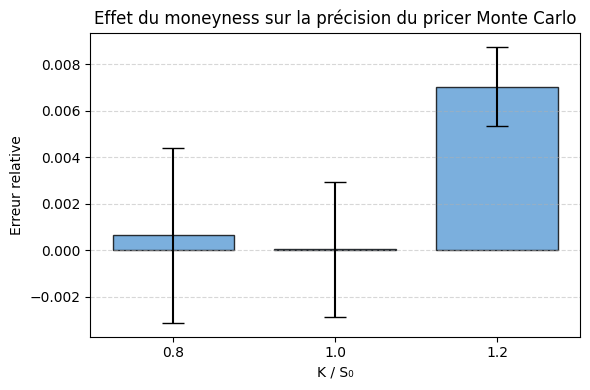

In [12]:
# --- Figure F5 (version corrigée) : Effet du moneyness sur la précision du pricer Monte Carlo ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

S0 = 100
r = 0.05
sigma = 0.2
T = 1.0
option_type = "call"
n_sims = 10_000
seed = 42

Ks = [0.8 * S0, 1.0 * S0, 1.2 * S0]
os.makedirs("figures", exist_ok=True)

records = []
for K in Ks:
    price_bs = black_scholes_price(S0, K, T, r, sigma, option_type)
    mc_ret = mc_option_price(S0, K, T, r, sigma, option_type,
                             n_sims=n_sims, rng_seed=seed, return_std=True)
    if isinstance(mc_ret, tuple):
        price_mc, std_mc = mc_ret
    elif isinstance(mc_ret, dict):
        price_mc, std_mc = mc_ret.get("price"), mc_ret.get("std")
    else:
        price_mc = mc_option_price(S0, K, T, r, sigma, option_type,
                                   n_sims=n_sims, rng_seed=seed)
        std_mc = np.nan

    ic95 = 1.96 * std_mc / np.sqrt(n_sims)
    err_rel = abs(price_mc - price_bs) / price_bs

    records.append({
        "K/S0": round(K / S0, 1),
        "Erreur_relative": err_rel,
        "IC95": ic95
    })

df_moneyness = pd.DataFrame(records)

# --- Graphique plus lisible ---
plt.figure(figsize=(6, 4))
bars = plt.bar(
    df_moneyness["K/S0"],
    df_moneyness["Erreur_relative"],
    yerr=df_moneyness["IC95"],
    capsize=8,
    width=0.15,
    color="#5A9BD5",
    edgecolor="black",
    alpha=0.8,
)

plt.xticks(df_moneyness["K/S0"], labels=[f"{x:.1f}" for x in df_moneyness["K/S0"]])
plt.xlabel("K / S₀")
plt.ylabel("Erreur relative")
plt.title("Effet du moneyness sur la précision du pricer Monte Carlo")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

try:
    plt.savefig("figures/F5_moneyness_error_bars.png", dpi=300)
except Exception as e:
    print("Avertissement : plt.savefig bloqué (affichage inline).", e)

plt.show()
